# ML Capstone: Iceberg Classifier


## Domain Background

Icebergs presents threats to the ships navigation and various offshore activities. Especially, it as actual problem for the area offshore to Newfoundland and Labrador known as Iceberg Alley. The primary iceberg detection method for now is aerial reconnaissance using vessel-based monitoring data. Also, data received though satellites are widely being integrated now onto the monitoring systems greatly reduce monitoring cost. Additionally, Synthetic Aperture Radar (SAR) satellites can still monitor in various weather conditions such as clouds and fog.
However, manual visual classification of SAR images to identify iceberg is very time-consuming process. So, C‑CORE company (https://www.c-core.ca/) has developed a computer vision system that analyzes SAR data to automatically detect and classify icebergs and vessels. Now it challenges ML community to build effective classification algorithm for their detection system [1]

## Problem Statement

The goal of the project is to build an algorithm which can reliably classify data to identify either it is iceberg or ship, based on given Synthetic Aperture Radar data. Also, the results are clearly measurable using prediction accuracy and it is important to have classifier with higher accuracy (ideally 100%).
Additionally, analysis and classification SAR data is interesting problem. Even if it seems like standard image classification task it has some important differences which makes it challengeable to use pre-trained neural networks with transfer learning for the image classification such as VGG [2] or Inception [3]:
• SAR data is not a three-channels regular image
• Radar detected shapes are different than visually detected shapes.
• Data set has additional incidence angle parameter of which the image was taken. So, it is additional

#### Import nessesary libraries

In [1]:
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

## Datasets and Inputs

CORE provided dataset of satellite SAR images containing either a ship or an iceberg including 1604 training samples and 8424 test samples (5000 from them are autogenerated) Data was collected from SAR which bounces a signal off an object and records the echo, then that data is translated into an image. Two channels of image are provided: HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). See [4] for more details. Data was packed to the two JSON files (train.json, test.json). Each file consists of list of satellite images in following format:

Data was packed to the two JSON files (train.json, test.json). Each file consists of list of satellite images in following format: 
* Id of the image 
* band1 – flatten image data of the HH channel (5625 elements, 75x75 image), each element is float value measured in dB. 
* band2 – flatten image data of the HV channel (5625 elements, 75x75 image) , each element is float value measured in dB. 
* inc_angle - the incidence angle of which the image was taken 
* is_iceberg – classification label of the image. 1 is for iceberg, 0 for ship.

Training dataset the only dataset which has labels assigned – so it will be used for training and validation. Test dataset does not have labels and will be used for the model evaluation.
For the model features we are going to use band1, band2 and inc_angle data as features and is_iceberg field as labels.


#### Utility function to load data from JSON file

In [2]:
def read_data(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    return data

#### Utility functions to find global dataset characteristics (signal strength min/max, angle min/max)

In [3]:
def find_signal_minmax(data):
    mins = [min(min(item['band_1']), min(item['band_2'])) for item in data ]
    maxes = [max(max(item['band_1']), max(item['band_2'])) for item in data ]

    global_min = min(mins)
    global_max = max(maxes)
    
    return global_min, global_max

def find_angle_minmax(data):
    global_min  = min( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'  ])
    global_max = max( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'])
  
    return global_min, global_max

#### Utility functions to extract and display 75*75 image from raw SAR JSON data

In [4]:
def extract_image(data_item, key, image_size = 75):
    image = np.array(data_item[key])
    image = image.reshape(image_size, image_size)
    return image
    
def extract_images(data_item, image_size = 75):
    hh_image = extract_image(data_item, 'band_1', image_size)
    hv_image = extract_image(data_item, 'band_2', image_size)
    return hh_image, hv_image
     
def display_image(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.show()

#### Image pre-processing and normalization functions

In [5]:
def global_min_max_scale_sar_image(image, global_min, global_max):
    image = (image - global_min) / (global_max - global_min)
    return image

def local_min_max_scale_sar_image(image):
    img_min = np.min(image)
    img_max = np.max(image)
    
    image = (image - img_min) / (img_max - img_min)
    return image

def local_standard_scale_sar_image(image):
    img_mean = np.mean(image)
    img_std = np.std(image)
    
    image = (image - np.ones_like(image) * img_mean) / img_std;
    
    return image

def flatten_image(image):
    image = image.flatten()
    return image

#### Create 2-channel Images for CNN from HH and HV SAR channels ignoring angle data

In [6]:
def prepare_dataset_ignore_angles(data, process_func):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        hh_image, hv_image = extract_images(item)
        hh_image = process_func(hh_image)
        hv_image = process_func(hv_image)
        
        image = np.dstack((hh_image, hv_image))
        X.append(image)
        if 'is_iceberg' in item.keys():
            labels.append(item['is_iceberg'])
        else:
            labels.append(0)
            
        ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

#### Create 3-channel Images for CNN from HH and HV SAR channels + angle data as separate layer

In [7]:
def prepare_dataset_with_angles(data, process_func, angle_processing):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item)
            hh_image = process_func(hh_image)
            hv_image = process_func(hv_image)
            angle_layer = np.ones_like(hh_image) * angle_processing(angle)
            image = np.dstack((hh_image, hv_image, angle_layer))
            X.append(image)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

#### Create flat features for simple classifiers algoirithms like Logistic Regression, Support vector machines

In [8]:
def prepare_flat_dataset_with_angles(data, process_func, angle_processing):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item)
            hh_image = process_func(hh_image).flatten()
            hv_image = process_func(hv_image).flatten()
            angle_layer = angle_processing(angle)
            x_item = np.concatenate((hh_image, hv_image, [angle_layer]))
            X.append(x_item)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

In [9]:
def cut_image_part(data, margin):
    return data[:, margin : -margin, margin : - margin, :]

#### Load training data

In [10]:
train_file = 'data/train.json'
train_data = read_data(train_file)
print('Training dataset size: {}'.format(len(train_data)))

Training dataset size: 1604


#### Find global parameters

In [11]:
image_size = 75

angle_min, angle_max = find_angle_minmax(train_data)
global_min, global_max = find_signal_minmax(train_data)

print("Minimum incidence angle = {}, Maximum incidence angle = {}".format(angle_min, angle_max))
print("Minimum signal strength (dB)= {}, Maximum signal strength (dB) = {}".format(global_min, global_max))

Minimum incidence angle = 24.7546, Maximum incidence angle = 45.9375
Minimum signal strength (dB)= -45.655499, Maximum signal strength (dB) = 34.574917


#### Prepare and run image workflow to  extract training data

In [12]:
import cv2

def process(image):
    image = local_min_max_scale_sar_image(image)
    #image = cv2.bilateralFilter(image.astype(np.float32), 5, 80, 80)
    return image
    
ptocessing_lambda = lambda image: process(image)
ptocessing_angle_lambda = lambda angle: 1.0 - (angle_max - angle) / (angle_max - angle_min)

#X_train_initial, y_train_initial, _ = prepare_dataset_ignore_angles(train_data, ptocessing_lambda)
X_train_initial, y_train_initial, _ = prepare_dataset_with_angles(train_data, ptocessing_lambda, ptocessing_angle_lambda)

#X_train, y_train, _ = prepare_dataset_with_angle(train_data, global_min, global_max, angle_min, angle_max)
print('Training dataset size: {}'.format(len(X_train_initial)))

Training dataset size: 1471


In [13]:
def get_image_channels(data, index):
    hh_channel = data[index, :, :, 0]
    hv_channel = data[index, :, :, 1]
    return hh_channel, hv_channel

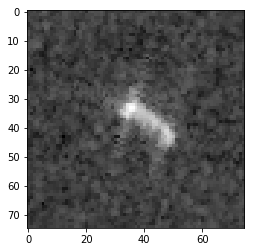

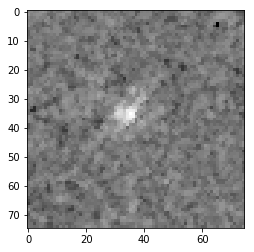

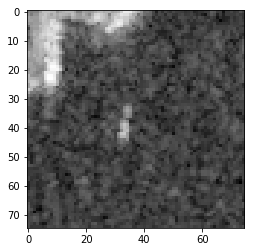

In [14]:
hh_channel, hv_channel = get_image_channels(X_train_initial, 24)
display_image(hh_channel)

hh_channel, hv_channel = get_image_channels(X_train_initial, 25)
display_image(hh_channel)

hh_channel, hv_channel = get_image_channels(X_train_initial, 26)
display_image(hh_channel)

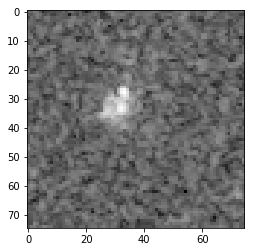

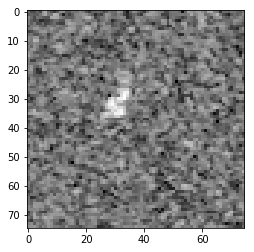

1


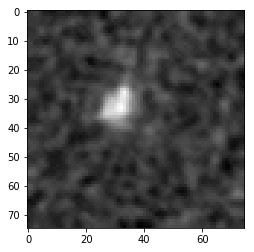

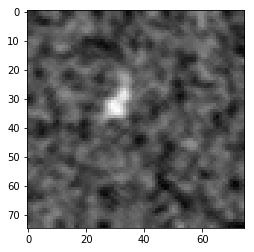

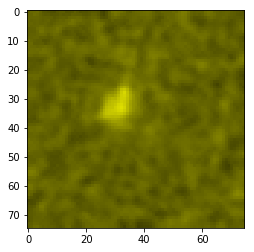

In [15]:
index = 1250

hh_image, hv_image =  get_image_channels(X_train_initial, index)
display_image(hh_image)
display_image(hv_image)

print(y_train_initial[index])

import cv2

hh_image = cv2.bilateralFilter(hh_image.astype(np.float32), 5, 80, 80)
hv_image = cv2.bilateralFilter(hv_image.astype(np.float32), 5, 80, 80)

display_image(hh_image)
display_image(hv_image)


image = np.dstack((hh_image, hh_image, np.zeros_like(hv_image)))
plt.imshow(image)
plt.show()

## Simple classifiers

In [57]:
import cv2

def process(image):
    image = local_min_max_scale_sar_image(image)
    return image
    
ptocessing_lambda = lambda image: process(image)
ptocessing_angle_lambda = lambda angle: 1.0 - (angle_max - angle) / (angle_max - angle_min)

X_flat_initial, y_flat_initial, _ = prepare_flat_dataset_with_angles(train_data, ptocessing_lambda, ptocessing_angle_lambda)

print('Training dataset size: {}'.format(len(X_flat_initial)))

Training dataset size: 1471


#### Split initial dataset to training and validation set

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat_initial, y_flat_initial, test_size=0.2, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))

Final training dataset size: 1176
Final validation dataset size: 295


In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree  import DecisionTreeClassifier

from time import time
import json

clf1= LogisticRegression(random_state = 3)
clf2 = AdaBoostClassifier(random_state = 3)
clf3 = SVC(random_state = 3)
clf4 = DecisionTreeClassifier(random_state = 3)

from sklearn.metrics import log_loss, accuracy_score 

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    start = time() # Get start time
  
    learner.fit(X_train, y_train)
    
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    X_train_pred = X_train[:300]
    y_train_pred = y_train[:300]
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_pred)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train_pred, predictions_train)
    results['log_loss_train'] = log_loss(y_train_pred, predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['log_loss_test'] = log_loss(y_test, predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, len(X_train)))
        
    # Return the results
    return results

print(train_predict(clf1, X_train, y_train, X_valid, y_valid))
print(train_predict(clf2, X_train, y_train, X_valid, y_valid))
print(train_predict(clf3, X_train, y_train, X_valid, y_valid))


LogisticRegression trained on 1176 samples.
{'acc_test': 0.80000000000000004, 'log_loss_test': 6.9078393044748019, 'log_loss_train': 9.9920072216264148e-16, 'pred_time': 0.07007789611816406, 'train_time': 3.447303056716919, 'acc_train': 1.0}


KeyboardInterrupt: 

In [19]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import fbeta_score, make_scorer

dtc = DecisionTreeClassifier(random_state = 3)

clf_default = AdaBoostClassifier(random_state = 3, base_estimator = dtc) 
clf = AdaBoostClassifier(random_state = 3, base_estimator = dtc)

# TODO: Create the parameters list you wish to tune
parameters = { 'n_estimators': [5, 10, 20, 50, 100], \
              # 'base_estimator__criterion' : ['gini', 'entropy'], \
               'base_estimator__max_depth': [2, 3, 5, 10, None] \
             #  'base_estimator__min_samples_split': [2, 5, 10, 50], \
             #  'base_estimator__class_weight': [{ 1 : 0.75}, { 1 : 1}] 
             } 

scorer = make_scorer(log_loss, greater_is_better=False)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


KeyboardInterrupt: 

In [73]:
def_model = clf_default.fit(X_train, y_train)

In [74]:
# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = def_model.predict(X_valid)
best_predictions = best_clf.predict(X_valid)

print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print ("log_loss on testing data: {:.4f}".format(log_loss(y_valid, predictions)))

print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))
print ("Final log_loss on the testing data: {:.4f}".format(log_loss(y_valid, best_predictions)))
                                                                     
print (grid_fit.best_params_)

Unoptimized model
------
Accuracy score on testing data: 0.7254
log_loss on testing data: 9.4837

Optimized Model
------
Final accuracy score on the testing data: 0.7254
Final log_loss on the testing data: 9.4837
{'n_estimators': 10}


#### Split initial dataset to training and validation set

In [53]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_initial, y_train_initial, test_size=0.05, random_state=142)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.33, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))
print('Final tet dataset size: {}'.format(len(X_test_1)))

Final training dataset size: 935
Final validation dataset size: 462
Final tet dataset size: 74


In [41]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=180, width_shift_range = 0.05, height_shift_range = 0.05, 
                             horizontal_flip = True, vertical_flip = True)
datagen.fit(X_train)

#X_train_new = np.copy(X_train)
#Y_train_new = np.copy(y_train)

#for i in range(40):
#    X_batch, y_batch =  next(datagen.flow(X_train, y_train, batch_size=2000))
#    if i == 0:
#        X_train_new = X_batch
#        Y_train_new = y_batch
#    else: 
#        X_train_new = np.concatenate((X_train_new, X_batch), axis=0)
#        Y_train_new = np.concatenate((Y_train_new, y_batch), axis=0)
    
    #plt.imshow(X_batch[24, :, :, 0])
    #plt.show()
                                    
    
#print(X_batch.shape)


#print (X_batch.shape)
##X_train = cut_image_part(X_train_new, 10)
#print (X_train_new.shape)







## Inception

In [85]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_initial, y_train_initial, test_size=0.2, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))

features_train = []
features_valid = []

for x in X_train:
    x = np.expand_dims(x, axis = 0)
    feature = model.predict(x)
    flat = feature.flatten()
    features_train.append(flat)

for x in X_valid:
    x = np.expand_dims(x, axis = 0)
    feature = model.predict(x)
    flat = feature.flatten()
    features_valid.append(flat)


C:\Users\Alexeys\AppData\Local\Continuum\Anaconda3\envs\aind-cv\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Final training dataset size: 1176
Final validation dataset size: 295


In [91]:
lrc = LogisticRegression(random_state = 3)
lrc = SVC(random_state = 3)

results = {}
    
start = time() # Get start time
lrc.fit(features_train, y_train)
end = time() # Get end time
results['train_time'] = end - start


start = time() # Get start time
predictions_test = lrc.predict(features_valid)
predictions_train = lrc.predict(features_train)
end = time() # Get end time
    
results['pred_time'] = end - start
results['acc_train'] = accuracy_score(y_train, predictions_train)
results['log_loss_train'] = log_loss(y_train, predictions_train)
results['acc_test'] = accuracy_score(y_valid, predictions_test)
results['log_loss_test'] = log_loss(y_valid, predictions_test)
       
print ("{} trained on {} samples.".format(lrc.__class__.__name__, len(features_train)))

results

SVC trained on 1176 samples.


{'acc_test': 0.8067796610169492,
 'acc_train': 0.81037414965986398,
 'log_loss_test': 6.6736943715756825,
 'log_loss_train': 6.549559751726858,
 'pred_time': 4.1282172203063965,
 'train_time': 3.5089163780212402}

## Model

In [92]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.initializers import RandomNormal
from keras.regularizers import l2

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model


entities_count = 20

def getModel10(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

def getModel11(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model
 


def getModel20(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model


def getTransferLearningModel():
    activation = 'elu'
    base_model = InceptionV3(include_top=False, weights='imagenet')
    output = base_model.output
    
    layer = GlobalMaxPooling2D()(output)
    layer = Dense(512, activation='relu', name='fc2')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(512, activation='relu', name='fc3')(layer)
    layer = Dropout(0.3)(layer)
    predictions = Dense(1, activation='sigmoid')(layer)
   
    model = Model(input=base_model.input, output=predictions)
  
    return model

In [93]:
def getModel30(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel32(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
 

    
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation="sigmoid"))
    
    
    return model

def getModel31(num_layers):
    activation = 'relu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel40(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False,
                     kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model



def getModel50(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [94]:
model = getModel11(3)
#model = getTransferLearningModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 75, 75, 64)        1728      
_________________________________________________________________
activation_118 (Activation)  (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 75, 75, 64)        36864     
_________________________________________________________________
activation_119 (Activation)  (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 38, 38, 128)       73728     
_________________________________________________________________
activation_120 (Activation)  (None, 38, 38, 128)       0         
__________

In [95]:
batch_size = 64
epochs = 150

def init_model(model, file_name):
    checkpointer = ModelCheckpoint(filepath=file_name, verbose=1, save_best_only=True)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
    optimizer_small = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
    optimizer2 = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    return model, checkpointer

In [144]:
from keras.callbacks import ModelCheckpoint  
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from keras.models import load_model

X_train_initial2 = X_train_initial[:,:,:, 1:3]
X_train, X_test, y_train, y_test = train_test_split(X_train_initial2, y_train_initial, test_size=0.1, random_state=147)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final test dataset size: {}'.format(len(X_test)))

K = 4
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=42).split(X_train, y_train))

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=180, width_shift_range = 0.05, height_shift_range = 0.05, 
                             horizontal_flip = True, vertical_flip = True)

#res = model.fit(train_tensors, train_targets, 
#          validation_data = (X_valid, y_valid),
#          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)
mean_loss = 0

for i, (train_idx, valid_idx) in enumerate(folds):
    print("Fold: {}".format(i))
    file_name = 'saved_models/fold{}.weights.best.from_scratch.hdf5'.format(i)

    model, checkpointer = init_model(getModel20(2), file_name)
    
    X_train_ = X_train[train_idx]
    y_train_ = y_train[train_idx]
    X_valid_ = X_train[valid_idx]
    y_valid_ =  y_train[valid_idx]

    datagen.fit(X_train_)

    res = model.fit_generator(datagen.flow(X_train_, y_train_, batch_size=batch_size),  steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid_, y_valid_), verbose=1, callbacks=[checkpointer])
    
    
    prediction_model = load_model(file_name )
    
    test_score = prediction_model.evaluate(X_test, y_test)
 
    print('Test loss:', test_score[0])
    print('Test accuracy:', test_score[1])
    
    mean_loss += test_score[0] / K
        
#res = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
#                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid, y_valid), verbose=1, callbacks=[checkpointer])

print('Mean loss:',   mean_loss)

Final training dataset size: 1323
Final test dataset size: 148
Fold: 0


C:\Users\Alexeys\AppData\Local\Continuum\Anaconda3\envs\aind-cv\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (992, 75, 75, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
C:\Users\Alexeys\AppData\Local\Continuum\Anaconda3\envs\aind-cv\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (992, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/150
21/20 [==============================] - 7s - loss: 0.7500 - acc: 0.5633 - val_loss: 0.6560 - val_acc: 0.6344
Epoch 2/150
21/20 [==============================] - 4s - loss: 0.6363 - acc: 0.6614 - val_loss: 0.6247 - val_acc: 0.6556
Epoch 3/150
21/20 [==============================] - 4s - loss: 0.6119 - acc: 0.6696 - val_loss: 0.6260 - val_acc: 0.6375
Epoch 4/150
21/20 [==============================] - 4s - loss: 0.5898 - acc: 0.6959 - val_loss: 0.5867 - val_acc: 0.6828
Epoch 5/150
21/20 [==============================] - 4s - loss: 0.5823 - acc: 0.7001 - val_loss: 0.5835 - val_acc: 0.7009
Epoch 6/150
21/20 [==============================] - 4s - loss: 0.5631 - acc: 0.7217 - val_loss: 0.5672 - val_acc: 0.7100
Epoch 7/150
21/20 [==============================] - 4s - loss: 0.5444 - acc: 0.7380 - val_loss: 0.5543 - val_acc: 0.7009
Epoch 8/150
21/20 [==============================] - 5s - loss: 0.5350 - acc: 0.7291 - val_loss: 0.5360 - val_acc: 0.7251
Epoch 9/150
21/20 [=====

21/20 [==============================] - 5s - loss: 0.4135 - acc: 0.7910 - val_loss: 0.4681 - val_acc: 0.7915
Epoch 31/150
21/20 [==============================] - 5s - loss: 0.4250 - acc: 0.8021 - val_loss: 0.4763 - val_acc: 0.7674
Epoch 32/150
21/20 [==============================] - 4s - loss: 0.4076 - acc: 0.8089 - val_loss: 0.4520 - val_acc: 0.7674
Epoch 33/150
21/20 [==============================] - 4s - loss: 0.3590 - acc: 0.8184 - val_loss: 0.4571 - val_acc: 0.7885
Epoch 34/150
21/20 [==============================] - 4s - loss: 0.3912 - acc: 0.8200 - val_loss: 0.4604 - val_acc: 0.7613
Epoch 35/150
21/20 [==============================] - 4s - loss: 0.3552 - acc: 0.8319 - val_loss: 0.4300 - val_acc: 0.7855
Epoch 36/150
21/20 [==============================] - 4s - loss: 0.3586 - acc: 0.8213 - val_loss: 0.4485 - val_acc: 0.7885
Epoch 37/150
21/20 [==============================] - 4s - loss: 0.3665 - acc: 0.8319 - val_loss: 0.4422 - val_acc: 0.7764
Epoch 38/150
21/20 [=========

21/20 [==============================] - 4s - loss: 0.3460 - acc: 0.8303 - val_loss: 0.4736 - val_acc: 0.7613
Epoch 65/150
21/20 [==============================] - 4s - loss: 0.3561 - acc: 0.8341 - val_loss: 0.4330 - val_acc: 0.7946
Epoch 66/150
21/20 [==============================] - 4s - loss: 0.3267 - acc: 0.8430 - val_loss: 0.4330 - val_acc: 0.7825
Epoch 67/150
21/20 [==============================] - 4s - loss: 0.3423 - acc: 0.8355 - val_loss: 0.4331 - val_acc: 0.7855
Epoch 68/150
21/20 [==============================] - 4s - loss: 0.3632 - acc: 0.8304 - val_loss: 0.4462 - val_acc: 0.7855
Epoch 69/150
21/20 [==============================] - 4s - loss: 0.3567 - acc: 0.8261 - val_loss: 0.4214 - val_acc: 0.7946
Epoch 70/150
21/20 [==============================] - 5s - loss: 0.3451 - acc: 0.8311 - val_loss: 0.4173 - val_acc: 0.8066
Epoch 71/150
21/20 [==============================] - 4s - loss: 0.3288 - acc: 0.8481 - val_loss: 0.4226 - val_acc: 0.7885
Epoch 72/150
21/20 [=========

KeyboardInterrupt: 

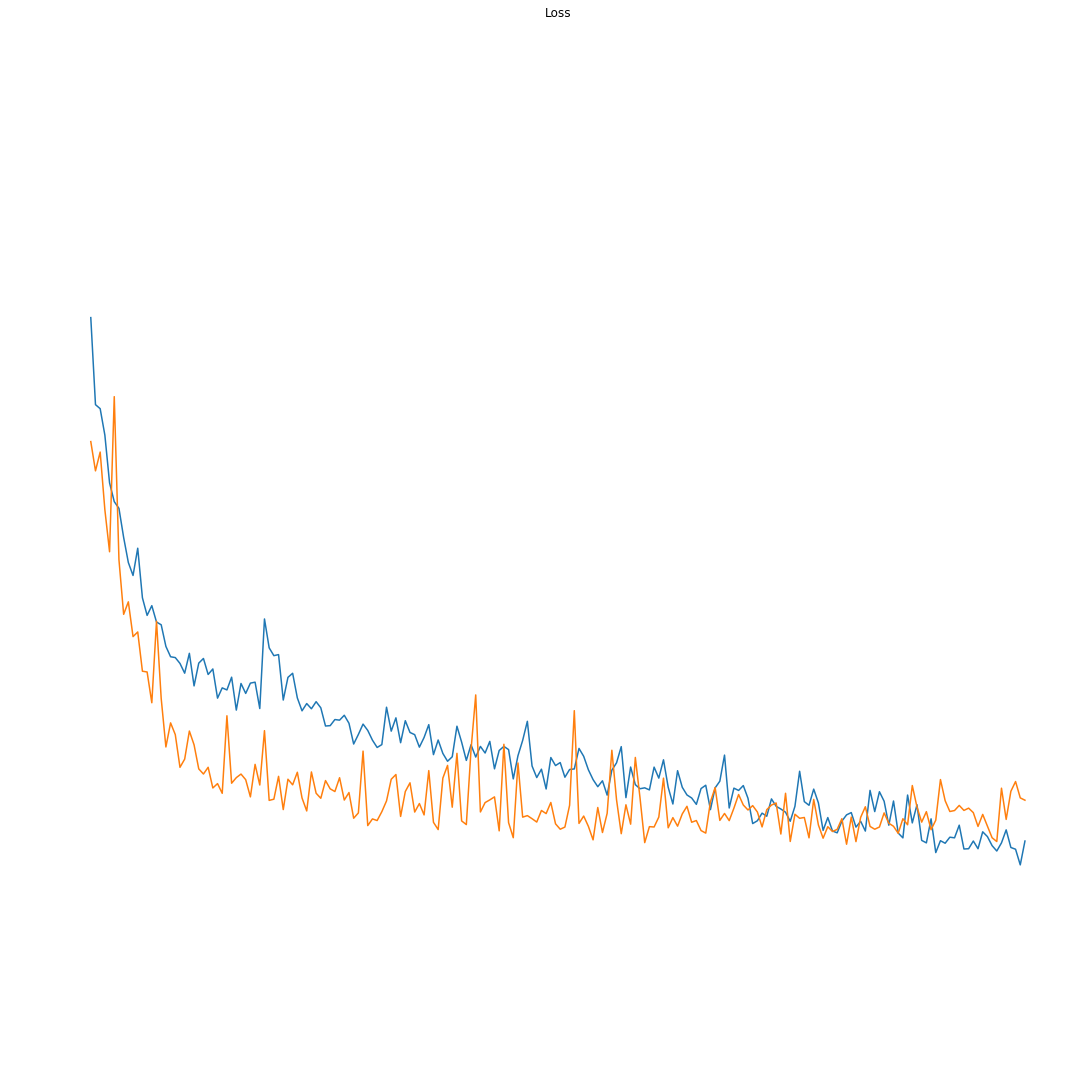

In [35]:
graphs = [res]

fig = plt.figure(figsize = (15, 15))
plt.axis('off')
plt.tight_layout()

for i, hist in enumerate(graphs):
    ax1 = fig.add_subplot(110 + i + 1)
    #plt.setp([ax1], xticks=[], yticks=[])
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Loss")
    ax1.set_ylabel('loss')
    #ax1.set_xlabel('epoch')
    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.xaxis.set_ticks(np.arange(0, epochs, epochs // 10))
    ax1.yaxis.set_ticks(np.arange(0, 1, 0.2))


In [43]:
test_file = 'data/test.json'
test_data = read_data(test_file)

In [ ]:
#X_test, y_test, ids = prepare_dataset_ignore_angle(test_data, global_min, global_max)
X_test, y_test, ids = prepare_dataset_with_angles(test_data, ptocessing_lambda, ptocessing_angle_lambda)

In [34]:
from keras.models import load_model

prediction_model = load_model('saved_models/fold1.weights.best.from_scratch.hdf5')


In [44]:
prediction_model_0 = load_model('saved_models/fold0.weights.best.from_scratch.hdf5')
prediction_model_1 = load_model('saved_models/fold1.weights.best.from_scratch.hdf5')
prediction_model_2 = load_model('saved_models/fold2.weights.best.from_scratch.hdf5')
prediction_model_3 = load_model('saved_models/fold3.weights.best.from_scratch.hdf5')



In [53]:
X_train__, X_test__, y_train__, y_test__ = train_test_split(X_train_initial, y_train_initial, test_size=0.1, random_state=147)

res1 = prediction_model_0.predict(X_train__)
res2 = prediction_model_1.predict(X_train__)
res3 = prediction_model_2.predict(X_train__)
res4 = prediction_model_3.predict(X_train__)

res1v = prediction_model_0.predict(X_test__)
res2v = prediction_model_1.predict(X_test__)
res3v = prediction_model_2.predict(X_test__)
res4v = prediction_model_3.predict(X_test__)

In [97]:
print(res4v[0])

[ 0.0081367]


In [102]:
res_f = np.concatenate([res1, res2, res3, res4], axis = 1)
res_f_v = np.concatenate([res1v, res2v, res3v, res4v], axis = 1)\

res_f_mean = np.mean(res_f, axis=1)
res_f_v_mean = np.mean(res_f_v, axis=1)
print(res_f_mean.shape)

print(log_loss(y_train__, res_f_mean))
print(log_loss(y_test__, res_f_v_mean))

(1323,)
0.197362782945
0.242118956725


In [135]:
d = np.sort(res_f_v, axis=1, kind='quicksort', order=None)
d1 = np.sort(res_f_v, axis=1, kind='quicksort', order=None)

rr = []
for item in d1:
    if np.mean(item) > 0.5:
        rr.append(np.max(item))
    else:
        rr.append(np.min(item))

print(y_test__.shape)
d = np.concatenate([d, np.expand_dims(y_test__, axis=1)], axis = 1)

#d = d[:,3:4]
print(log_loss(y_test__, rr))

for i in range(132):
    print(i, d[i])


(148,)
0.239871991572
0 [ 0.0081367   0.01250578  0.10172801  0.13523762  0.        ]
1 [ 0.88858986  0.92814356  0.95266861  0.99112976  0.        ]
2 [  2.64809490e-08   1.15456987e-06   5.61911020e-06   2.97716961e-05
   0.00000000e+00]
3 [  1.58721514e-06   2.04886492e-05   5.53732134e-05   7.51627231e-05
   0.00000000e+00]
4 [  2.01802832e-05   5.77110004e-05   1.22689904e-04   4.03570244e-03
   0.00000000e+00]
5 [  1.76842349e-07   1.46630134e-06   2.91814849e-05   2.50034616e-04
   0.00000000e+00]
6 [ 0.8775596   0.91833168  0.96299773  0.97456735  0.        ]
7 [ 0.4308446   0.5292275   0.77527428  0.803617    1.        ]
8 [ 0.95533025  0.95781356  0.9635247   0.96544582  1.        ]
9 [ 0.83187395  0.84829634  0.88617963  0.90006959  0.        ]
10 [ 0.95898587  0.9737941   0.98851317  0.99569619  0.        ]
11 [  3.13955212e-07   3.67417510e-06   2.32146485e-05   3.92158399e-04
   0.00000000e+00]
12 [ 0.0618963   0.0837003   0.26627043  0.46775448  0.        ]
13 [ 0.546042

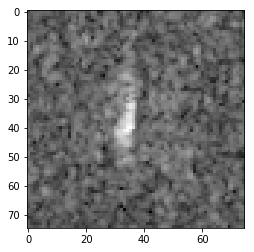

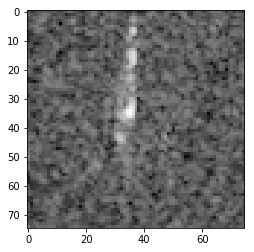

In [139]:
hh_channel, hv_channel = get_image_channels(X_test__, 6)
display_image(hh_channel)
display_image(hv_channel)


In [62]:


lrc = AdaBoostClassifier(random_state = 3)
#lrc = SVC(random_state = 3)

results = {}
    
start = time() # Get start time
lrc.fit(res_f, y_train__)
end = time() # Get end time
results['train_time'] = end - start


start = time() # Get start time
predictions_test = lrc.predict(res_f_v)
predictions_train = lrc.predict(res_f)
end = time() # Get end time
    
results['pred_time'] = end - start
results['acc_train'] = accuracy_score(y_train__, predictions_train)
results['log_loss_train'] = log_loss(y_train__, predictions_train)
results['acc_test'] = accuracy_score(y_test__, predictions_test)
results['log_loss_test'] = log_loss(y_test__, predictions_test)
       
print ("{} trained on {} samples.".format(lrc.__class__.__name__, len(res_f)))

results


(1323, 1)
(1323, 4)
AdaBoostClassifier trained on 1323 samples.


{'acc_test': 0.89864864864864868,
 'acc_train': 0.92970521541950113,
 'log_loss_test': 3.5005948831290667,
 'log_loss_train': 2.4279309005122043,
 'pred_time': 0.015637874603271484,
 'train_time': 0.09164977073669434}

In [37]:
print(X_test.shape)

(8424, 75, 75, 3)


In [38]:
res = prediction_model.predict(X_test)

In [39]:
print(res.shape)

(8424, 1)


In [40]:
print(y_test.shape)

(8424,)


In [41]:
print(y_test)

[0 0 0 ..., 0 0 0]


In [42]:
import csv
headers = ['id', 'is_iceberg']

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(headers)

    for prediction, item_id in zip(res, ids):
        csv_writer.writerow([item_id, np.asscalar(prediction)])

    